## Introdução

Ao longo do nosso curso, fomos apresentados a diversos conceitos e técnicas que moldam o campo da geometria computacional. Um dos desafios mais intrigantes é a tarefa de classificação, onde buscamos categorizar dados com base em suas características. Neste trabalho, vamos explorar a implementação prática de modelos de classificação em aprendizado supervisionado, com ênfase na determinação da separabilidade linear dos dados. Através desta investigação, esperamos não apenas solidificar nosso entendimento dos tópicos discutidos em sala de aula, mas também avaliar a eficácia e precisão dos modelos lineares em conjuntos de dados reais. Com experimentos cuidadosamente planejados e uma análise aprofundada dos resultados, buscamos oferecer insights valiosos sobre a aplicabilidade e limitações dos classificadores lineares no mundo real.


### Participantes dos Grupos

# Lista de Participantes e Matrículas

**Arthur Linhares Madureira**: 2021031599

**Henrique da Fonseca Diniz Freitas**: 2021031688

**Marcelo Augusto Mrad Marteleto**: 2021031548



**INSTALAÇÃO DAS BIBLIOTECAS**


In [26]:
%pip install sortedcontainers
%pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


**IMPORTANDO AS BIBLIOTECAS NECESSÁRIAS**


In [27]:
#import das bibliotecas necessárias
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from functools import cmp_to_key
from sortedcontainers import SortedList
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


***ORIENTAÇÃO:*** Determina a orientação do trio ordenado (p, q, r). Se o resultado for 0, então colinear. Se for 1, então horário. Se for -1, então anti-horário.


***NO_SEGMENTO:*** Verifica se o ponto q está no segmento PR


In [28]:
def define_orientacao(p, q, r):
    """
    Determina a orientação do trio ordenado (p, q, r).
    Se o resultado for 0, então colinear
    Se for 1, então horário
    Se for -1, então anti-horário
    """
    val = (q.y - p.y) * (r.x - q.x) - (q.x - p.x) * (r.y - q.y)
    if val == 0:
        return 0
    return 1 if val > 0 else -1


def verifica_segmento(p, q, r):
    """
    Verifica se o ponto q está no segmento pr
    """
    return (q.x <= max(p.x, r.x) and q.x >= min(p.x, r.x) and
            q.y <= max(p.y, r.y) and q.y >= min(p.y, r.y))


## Classes Utilizadas
A criação de classes foi utilizada para fornecer uma abordagem intuitiva e eficiente durante a implementação dos algoritmos e para deixar o código mais reutilizavél.

### Classe Ponto
A classe `Ponto` serve como uma representação de um ponto no plano cartesiano. Seu principal propósito é definir posições e permitir operações aritméticas básicas entre pontos. Esta classe é essencial para realizar cálculos e manipular pontos.

### Classe Segmento
A classe `Segmento` foi projetada para representar um segmento de reta no plano cartesiano, definido por dois pontos. Ela desempenha um papel crucial na determinação de relações entre segmentos de reta, como detectar interseções. Esta classe fornece as funcionalidades necessárias para analisar e comparar segmentos de reta com precisão.

### Classe Evento
A classe `Evento` é especificamente adaptada para algoritmos de varredura linear.Esta classe auxilia no processamento e ordenação de eventos que ocorrem durante a varredura de forma a gerenciar eventos de forma eficiente.

In [29]:
class Ponto:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __sub__(self, other):
        return Ponto(self.x - other.x, self.y - other.y)

    def __repr__(self):
        return f"({self.x}, {self.y})"

    def distancia_ao_quadrado(self, other):
        return (self.x - other.x)**2 + (self.y - other.y)**2

class Segmento:
    def __init__(self, p1, p2):
        self.p1 = p1
        self.p2 = p2
    def __repr__(self):
        return f"[{self.p1}, {self.p2}]"

    def __hash__(self):
        return hash((self.p1, self.p2))

    def __eq__(self, other):
        return isinstance(other, Segmento) and {self.p1, self.p2} == {other.p1, other.p2}

    def intersecao(self, other):
        o1 = define_orientacao(self.p1, self.p2, other.p1)
        o2 = define_orientacao(self.p1, self.p2, other.p2)
        o3 = define_orientacao(other.p1, other.p2, self.p1)
        o4 = define_orientacao(other.p1, other.p2, self.p2)

        # Condições principais de interseção
        if o1 * o2 < 0 and o3 * o4 < 0:
            return True

        # Casos especiais: se os segmentos são colineares e se cruzam
        if o1 == 0 and verifica_segmento(self.p1, other.p1, self.p2):
            return True
        if o2 == 0 and verifica_segmento(self.p1, other.p2, self.p2):
            return True
        if o3 == 0 and verifica_segmento(other.p1, self.p1, other.p2):
            return True
        if o4 == 0 and verifica_segmento(other.p1, self.p2, other.p2):
            return True

        return False


    def produto_vetorial(self, other):
        return (self.p2.x - self.p1.x) * (other.p2.y - other.p1.y) - (self.p2.y - self.p1.y) * (other.p2.x - other.p1.x)

    def __lt__(self, other):
        return self.p1.y < other.p1.y or (self.p1.y == other.p1.y and self.p2.y < other.p2.y)

class Event:
    def __init__(self, x, y, segment, is_start, poligono):
        self.x = x
        self.y = y
        self.segment = segment
        self.is_start = is_start
        self.poligono = poligono

    def __lt__(self, other):
        if self.x != other.x:
            return self.x < other.x
        return self.y < other.y

## Função de Ordenação Polar


A função `ordenacao_polar` é usada para ordenar pontos com base em seus ângulos polares em relação a um ponto de referência `p0`.


### Parâmetros:
- `p0`: Ponto de referência em relação ao qual os outros pontos serão ordenados.


**Lógica de Comparação**:
1. Se `p1` e `p2` são colineares em relação a `p0`, a distância deles até `p0` é comparada. O ponto mais próximo de `p0` é considerado menor.
2. Se não são colineares, o ponto que forma um ângulo menor (ou seja, está à direita ao observar a partir de `p0`) é considerado menor.


**Retorno**:
- `-1` se `p1` vem antes de `p2`.
- `1` se `p1` vem depois de `p2`.


In [30]:
def ordenacao_polar(p0):
    def compare(p1, p2):
        o = define_orientacao(p0, p1, p2)
        if o == 0:
            if p1.distancia_ao_quadrado(p0) < p2.distancia_ao_quadrado(p0):
                return -1
            else:
                return 1
        return 1 if o > 0 else -1
    return compare


## Algoritmo de Graham Scan para Envolvória Convexa


O algoritmo de Graham Scan é uma abordagem eficiente para encontrar a envoltória convexa de um conjunto de pontos no plano. A envoltória convexa é o menor polígono convexo que contém todos os pontos de um conjunto.


### **Passo a passo da função `graham_scan`:**


1. **Verificação inicial de quantidade de pontos**:
- Caso haja menos de 3 pontos no conjunto, a função retorna diretamente os pontos originais, pois não é possível formar uma envoltória convexa com menos de 3 pontos.




2. **Encontrando o ponto de partida, `p0`**:
- Os pontos são ordenados primeiramente pela coordenada `y` e, em caso de empate, pela coordenada `x`.
- O ponto mais à esquerda e mais abaixo (menor `y` e menor `x`) é escolhido como `p0`.




3. **Ordenação Polar dos Pontos**:
- Todos os pontos, exceto `p0`, são ordenados de acordo com seus ângulos polares em relação a `p0`.




4. **Construção da Envolvória Convexa**:
- Inicializamos a envoltória com `p0` e o primeiro ponto da lista ordenada.
- Percorremos os pontos ordenados e continuamos adicionando à envoltória até que seja garantido que a envoltória permaneça convexa.




5. **Fechamento da Envolvória**:
- Para fechar o polígono convexo, adicionamos o ponto `p0` novamente ao final da envoltória.

In [31]:
#Algoritmo de Graham Scan para criar a envoltoŕia convexa

def graham_scan(pontos):
    if len(pontos) < 3:
        return pontos  # Retorna os pontos originais se houver menos de 3

    pontos = sorted(pontos, key=lambda p: (p.y, p.x))
    p0 = pontos[0]
    pontos_ordenados = sorted(pontos[1:], key=cmp_to_key(ordenacao_polar(p0)))

    envoltoria = [p0, pontos_ordenados[0]]
    for p in pontos_ordenados[1:]:
        while len(envoltoria) > 1 and Segmento(envoltoria[-2], envoltoria[-1]).produto_vetorial(Segmento(envoltoria[-1], p)) <= 0:
            envoltoria.pop()
        envoltoria.append(p)

    if len(envoltoria) > 2:
        envoltoria.append(p0)

    return envoltoria



## Visualização da Envolvória Convexa


Para visualizar o conjunto de pontos e sua envoltória convexa, é definida a função `plot_envoltoria`.


### Função `plot_envoltoria`


A função toma como entrada dois conjuntos de pontos:
- `pontos`: O conjunto completo de pontos.
- `envoltoria`: A envoltória convexa calculada.


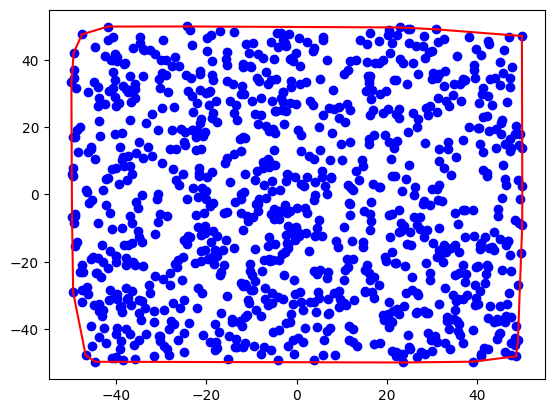

In [32]:
# Função para plotar a envoltória convexa

def plot_envoltoria(pontos, envoltoria):
    # Plotar todos os pontos
    plt.scatter([p.x for p in pontos], [p.y for p in pontos], color='b')

    # Plotar a envoltória convexa
    for i in range(len(envoltoria) - 1):
        plt.plot([envoltoria[i].x, envoltoria[i+1].x], [envoltoria[i].y, envoltoria[i+1].y], color='r')

    # Fechar a envoltória
    plt.plot([envoltoria[-1].x, envoltoria[0].x], [envoltoria[-1].y, envoltoria[0].y], color='r')

    plt.show()

# Gerar pontos aleatórios para testar o algoritmo e posteriormente plotar a envoltória convexa
pontos = [Ponto(random.uniform(-50, 50), random.uniform(-50, 50)) for _ in range(1000)]
envoltoria = graham_scan(pontos)
plot_envoltoria(pontos, envoltoria)

## **Detectando Interseções de Segmentos**


A função `segmentos_que_se_cruzam` determina quais pares de segmentos se cruzam de uma lista de segmentos.


### **Funcionalidades**


1. `cruzam(seg1, seg2)`: Uma função auxiliar que determina se os segmentos `seg1` e `seg2` se cruzam.


2. `segmentos_que_se_cruzam(segmentos, poligonos)`: Esta é a principal função que retorna uma lista de pares de segmentos que se cruzam.


### **Descrição do Algoritmo**


1. **Inicialização**:
- Uma lista `eventos` é inicializada para armazenar eventos associados ao início e ao fim de cada segmento.


2. **População de Eventos**:
- Para cada segmento, os pontos de início e fim são determinados com base nas coordenadas x. Esses são adicionados à lista de `eventos`.


3. **Ordenação de Eventos**:
- Os eventos são ordenados com base nas coordenadas x e y dos pontos associados.


4. **Processamento de Eventos**:
- Uma lista ordenada `active_segments` é inicializada para armazenar segmentos ativos.
- Para cada evento na lista ordenada de eventos:
- Se o evento for do tipo 'start':
- Verifica-se possíveis interseções com segmentos adjacentes na lista `active_segments`.
- O segmento é então adicionado à lista `active_segments`.
- Se o evento for do tipo 'end':
- Verifica-se interseções entre os segmentos vizinhos.
- O segmento é removido de `active_segments`.


5. **Resultado**:
- A função retorna uma lista de pares de segmentos que se cruzam.


In [33]:
def cruzam(seg1, seg2):
    """ Verifica se os segmentos seg1 e seg2 se cruzam """
    # Usa sua função 'intersecao' já definida anteriormente
    return seg1.intersecao(seg2)


def segmentos_que_se_cruzam(segmentos, poligonos):
    segmento_para_poligono = {seg: pol for seg, pol in zip(segmentos, poligonos)}

    eventos = []
    for seg in segmentos:
        start = seg.p1 if seg.p1.x < seg.p2.x else seg.p2
        end = seg.p2 if seg.p1.x < seg.p2.x else seg.p1
        eventos.append((start, 'start', seg))
        eventos.append((end, 'end', seg))

    eventos.sort(key=lambda e: (e[0].x, e[0].y))

    # Usando SortedList da biblioteca sortedcontainers, com custo de inserção e remoção O(log n)
    segmentos_ativos = SortedList(key=lambda s: (s.p1.y + s.p2.y) / 2)
    intersecoes = set()

    for _, tipo, segmento in eventos:
        if tipo == 'start':
            idx = segmentos_ativos.bisect(segmento)

            # Verificar interseção com segmento abaixo
            if idx > 0 and segmento.intersecao(segmentos_ativos[idx - 1]) and segmento_para_poligono[segmento] != segmento_para_poligono[segmentos_ativos[idx - 1]]:
                intersecoes.add(tuple(sorted([segmento, segmentos_ativos[idx - 1]])))

            # Verificar interseção com segmento acima
            if idx < len(segmentos_ativos) and segmento.intersecao(segmentos_ativos[idx]) and segmento_para_poligono[segmento] != segmento_para_poligono[segmentos_ativos[idx]]:
                intersecoes.add(tuple(sorted([segmento, segmentos_ativos[idx]])))

            segmentos_ativos.add(segmento)
        else:
            if segmento in segmentos_ativos:
                segmento_idx = segmentos_ativos.index(segmento)

                # Verificar interseção entre segmentos vizinhos
                if 0 < segmento_idx < len(segmentos_ativos) - 1:
                    seg_below = segmentos_ativos[segmento_idx - 1]
                    seg_above = segmentos_ativos[segmento_idx + 1]
                    if seg_below.intersecao(seg_above) and segmento_para_poligono[seg_below] != segmento_para_poligono[seg_above]:
                        intersecoes.add(tuple(sorted([seg_below, seg_above])))

                segmentos_ativos.remove(segmento)

    return list(intersecoes)


## **Verificando Separabilidade Linear entre Duas Classes**


A função `verificar_separabilidade_linear` determina se dois conjuntos de pontos, `classe_1` e `classe_2`, podem ser linearmente separados.


### **Descrição do Algoritmo**


1. **Construção das Envoltórias Convexas**:
- Para cada conjunto de pontos, a envoltória convexa é construída usando o algoritmo de Graham Scan (`graham_scan`).


2. **Criação de Segmentos das Envoltórias**:
- Para cada envoltória convexa, criam-se segmentos de linha entre pontos consecutivos da envoltória.


3. **Verificação de Interseção entre Segmentos**:
- Todos os segmentos das duas classes são combinados em uma única lista `todos_os_segmentos`.
- Uma lista `poligonos` é criada para identificar a qual classe pertence cada segmento (1 para `classe_1` e 2 para `classe_2`).
- Utiliza-se a função `segmentos_que_se_cruzam` para determinar se existem interseções entre os segmentos das duas envoltórias.


4. **Resultado**:
- Se não houver interseções entre os segmentos das duas classes, as classes são linearmente separáveis e a função retorna `True`.
- Caso contrário, a função retorna `False`.


In [34]:
def verificar_separabilidade_linear(classe_1, classe_2):
    envoltoria_classe_1 = graham_scan(classe_1)
    envoltoria_classe_2 = graham_scan(classe_2)

    segmentos_classe_1 = [Segmento(envoltoria_classe_1[i], envoltoria_classe_1[i + 1]) for i in range(len(envoltoria_classe_1) - 1)]
    segmentos_classe_2 = [Segmento(envoltoria_classe_2[i], envoltoria_classe_2[i + 1]) for i in range(len(envoltoria_classe_2) - 1)]

    todos_os_segmentos = segmentos_classe_1 + segmentos_classe_2
    poligonos = [1] * len(segmentos_classe_1) + [2] * len(segmentos_classe_2)

    intersecoes = segmentos_que_se_cruzam(todos_os_segmentos, poligonos)
    return len(intersecoes) == 0


## Visualização da Separabilidade Linear entre Duas Classes


A função `plot_separabilidade` tem como objetivo ilustrar graficamente se dois conjuntos de pontos, representando duas classes distintas, são linearmente separáveis no plano. Isso é feito através da construção das envoltórias convexas de ambos os conjuntos e verificando se elas se cruzam ou não.



In [35]:
def plot_separabilidade(classe_1, classe_2):

    classe_1 = graham_scan(classe_1)
    classe_2 = graham_scan(classe_2)

    # Verificar se os dados são linearmente separáveis
    separaveis = verificar_separabilidade_linear(classe_1, classe_2)

    # Plotar envoltória da classe 1
    for i in range(len(classe_1) - 1):
        plt.plot([classe_1[i].x, classe_1[i + 1].x],
                 [classe_1[i].y, classe_1[i + 1].y], 'b-')

    # Plotar envoltória da classe 2
    for i in range(len(classe_2) - 1):
        plt.plot([classe_2[i].x, classe_2[i + 1].x],
                 [classe_2[i].y, classe_2[i + 1].y], 'r-')

    if separaveis:
        plt.title("Dados são linearmente separáveis!")
    else:
        plt.title("Dados não são linearmente separáveis!")

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

***Gerar pontos aleatórios para ambas as classes***


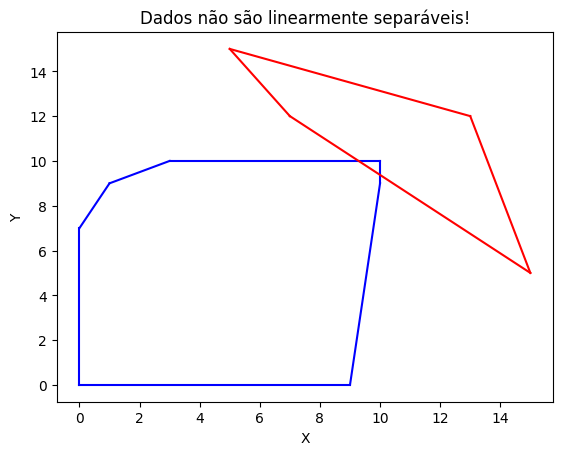

In [71]:
# Gerar pontos aleatórios para ambas as classes
classe_1_random = [Ponto(random.randint(0, 10), random.randint(0, 10)) for _ in range(50)]
classe_2_random = [Ponto(random.randint(5, 15), random.randint(5, 15)) for _ in range(15)]

plot_separabilidade(classe_1_random, classe_2_random)

# Modelo Linear Baseado em Envoltórios Convexos


Este código busca encontrar um modelo linear para separar dois conjuntos de pontos no plano, assumindo que os pontos de cada conjunto estejam agrupados e possam ser encapsulados por envoltórios convexos.


## Funções:


### 1. `encontrar_pontos_mais_proximos(env1, env2)`:
- **Entrada**: Dois envoltórios convexos (listas de pontos).
- **Saída**: Os pontos (um de cada envoltórios) que estão mais próximos entre si.
- **Funcionamento**: A função itera sobre todos os pares de pontos entre os dois envoltórios e determina os pontos mais próximos com base na distância ao quadrado.


### 2. `construir_modelo_linear(pontos1, pontos2)`:
- **Entrada**: Dois conjuntos de pontos.
- **Saída**: Uma reta (definida por sua inclinação `m` e interceptação `b`) que serve como um modelo linear entre os dois envoltórios convexos formados a partir dos pontos de entrada.
- **Funcionamento**: Esta função constrói os envoltórios convexos, verifica se são linearmente separáveis e, em seguida, calcula uma linha perpendicular ao segmento que liga os dois pontos mais próximos dos envelopes.


### 3. `plot_modelo(pontos1, pontos2)`:
- **Entrada**: Dois conjuntos de pontos.
- **Saída**: Um gráfico mostrando os dois envoltórios convexos, os pontos mais próximos e o modelo linear proposto.
- **Funcionamento**: Esta função visualiza os dados e o modelo linear. Os envoltórios convexos são plotados em azul e vermelho, respectivamente, e o modelo linear é mostrado como uma linha ciano. Os pontos mais próximos são conectados por uma linha tracejada verde.


In [37]:
def encontrar_pontos_mais_proximos(env1, env2):
    menor_distancia = float('inf')
    ponto1 = None
    ponto2 = None

    for p1 in env1:
        for p2 in env2:
            distancia = p1.distancia_ao_quadrado(p2)
            if distancia < menor_distancia:
                menor_distancia = distancia
                ponto1 = p1
                ponto2 = p2

    return ponto1, ponto2

def construir_modelo_linear(pontos1, pontos2):
    env1 = graham_scan(pontos1)
    env2 = graham_scan(pontos2)

    if not verificar_separabilidade_linear(env1, env2):
        print('Os dados não são linearmente separáveis.')
        return None

    ponto1, ponto2 = encontrar_pontos_mais_proximos(env1, env2)

    ponto_medio = Ponto((ponto1.x + ponto2.x) / 2, (ponto1.y + ponto2.y) / 2)
    vetor_direcao = Ponto(ponto2.x - ponto1.x, ponto2.y - ponto1.y)
    vetor_direcao_perpendicular = Ponto(vetor_direcao.y, -vetor_direcao.x)

    if vetor_direcao_perpendicular.x == 0:
        return 'vertical', ponto_medio.x, env1, env2
    else:
        m = vetor_direcao_perpendicular.y / vetor_direcao_perpendicular.x
        b = ponto_medio.y - m * ponto_medio.x
        return m, b, env1, env2

def plot_modelo(pontos1, pontos2):
    resultado = construir_modelo_linear(pontos1, pontos2)

    if resultado is None:
        return False

    modelo, b, env1, env2 = resultado

    ponto1, ponto2 = encontrar_pontos_mais_proximos(env1, env2)
    plt.fill([p.x for p in env1], [p.y for p in env1], color='blue', alpha=0.3)
    plt.fill([p.x for p in env2], [p.y for p in env2], color='red', alpha=0.3)
    plt.plot([p.x for p in env1 + [env1[0]]], [p.y for p in env1 + [env1[0]]], 'b-')
    plt.plot([p.x for p in env2 + [env2[0]]], [p.y for p in env2 + [env2[0]]], 'r-')
    plt.plot([ponto1.x, ponto2.x], [ponto1.y, ponto2.y], 'g--')

    if modelo == 'vertical':
        plt.axvline(x=b, color='c', label='Modelo Linear')
    else:
        m = modelo
        x_vals = [min([p.x for p in env1 + env2]), max([p.x for p in env1 + env2])]
        y_vals = [m*x+b for x in x_vals]
        plt.plot(x_vals, y_vals, 'c-', label='Modelo Linear')

    # Ajuste a escala dos eixos x e y conforme necessário
    # Defina os limites x e y para ajustar a escala do gráfico
    plt.xlim(min([p.x for p in env1 + env2]) - 1, max([p.x for p in env1 + env2]) + 1)
    plt.ylim(min([p.y for p in env1 + env2]) - 1, max([p.y for p in env1 + env2]) + 1)

    plt.legend()
    plt.show()

    return True


***Gerar pontos aleatórios para ambas as classes para testar novamente***


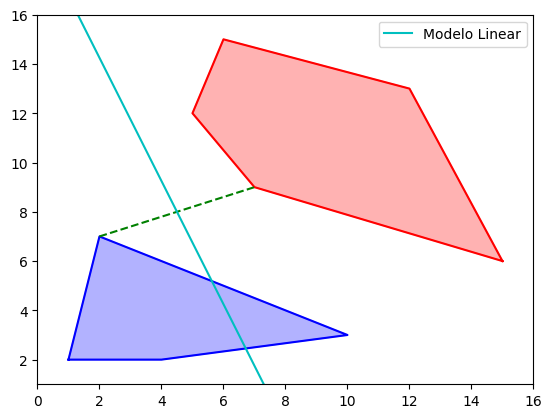

True

In [74]:
# Gerar pontos aleatórios para testar
classe_1_random = [Ponto(random.randint(0, 10), random.randint(0, 10)) for _ in range(5)]
classe_2_random = [Ponto(random.randint(5, 15), random.randint(5, 15)) for _ in range(10)]

plot_modelo(classe_1_random, classe_2_random)


# Aplicação do PCA (Análise de Componentes Principais)

O código acima define uma função que aplica a Análise de Componentes Principais (PCA) a um conjunto de dados, reduzindo suas dimensões para um número especificado. A função funciona da seguinte maneira:

## Função: `apply_pca(data, n_components=2)`

### **Entrada:**
- `data`: O conjunto de dados original que você deseja reduzir em dimensão.
- `n_components`: O número de componentes principais para o qual você deseja reduzir o conjunto de dados. O valor padrão é 2.

### **Processo:**

1. **Normalização**:
    - Antes de aplicar PCA, é essencial que os dados sejam normalizados. Isso garante que todas as características tenham igual importância durante a redução da dimensionalidade.
    - Utiliza-se a classe `StandardScaler` do scikit-learn para normalizar os dados de modo que tenham média 0 e desvio padrão 1.

2. **Aplicação do PCA**:
    - Utiliza-se a classe `PCA` do scikit-learn para realizar a redução da dimensionalidade.
    - A quantidade de componentes é definida pelo parâmetro `n_components`.

3. **Formatação da Saída**:
    - Os dados reduzidos são convertidos de volta para um DataFrame do pandas com nomes de colunas correspondentes aos componentes principais (por exemplo, "Componente 1", "Componente 2", ...).

### **Saída:**
- Retorna um DataFrame contendo os dados transformados com suas principais componentes.



In [39]:
def apply_pca(data, n_components=2):
    # Normaliza os dados
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(data)

    # Aplica PCA
    pca = PCA(n_components=n_components)
    reduced_data = pca.fit_transform(normalized_data)

    return pd.DataFrame(reduced_data, columns=[f'Componente {i+1}' for i in range(n_components)])

## Cálculo de métricas
Após a conclusão dos algoritmos para a implementação do modelo linear, será necessário o cálculo das métricas para avaliar o desempenho do classificador. Para isso, o código abaixo foi implementado, ele é útil para analisar e compreender a distribuição e classificação de pontos em um espaço 2D, calculando as metricas de  `precisão, revocação e f1-escore`.

In [40]:
def prever(modelo, ponto, positive_label, negative_label):
    m, c = modelo[:2]
    if ponto.y > m * ponto.x + c:
        return positive_label
    else:
        return negative_label

def calcular_metricas(label_name, test, modelo, positive_label, negative_label):
    verdadeiros = test[label_name].tolist()
    previstos = [prever(modelo, Ponto(row['Componente 1'], row['Componente 2']), positive_label, negative_label) for _, row in test.iterrows()]

    tp = sum(1 for v, p in zip(verdadeiros, previstos) if v == positive_label and p == positive_label)
    fp = sum(1 for v, p in zip(verdadeiros, previstos) if v == negative_label and p == positive_label)
    fn = sum(1 for v, p in zip(verdadeiros, previstos) if v == positive_label and p == negative_label)

    precisao = tp / (tp + fp) if tp + fp != 0 else 0
    revocacao = tp / (tp + fn) if tp + fn != 0 else 0
    f1 = 2 * (precisao * revocacao) / (precisao + revocacao) if (precisao + revocacao) != 0 else 0

    return precisao, revocacao, f1


def plotar_classificacao(pontos1, pontos2):
    # Extrair coordenadas x e y dos pontos para plotagem
    modelo = construir_modelo_linear(pontos1, pontos2)
    if modelo is None:
        return [],[]

    x1, y1 = zip(*[(p.x, p.y) for p in pontos1])
    x2, y2 = zip(*[(p.x, p.y) for p in pontos2])

    # Plotar os pontos
    plt.scatter(x1, y1, color='blue', label='Classe 1')
    plt.scatter(x2, y2, color='red', label='Classe 2')

    # Plotar a reta do modelo
    if modelo[0] == 'vertical':
        plt.axvline(x=modelo[1], color='green', linestyle='--', label='Reta do Modelo')
    else:
        # Criando uma sequência de valores x para a reta
        x_reta = list(range(int(min(x1 + x2)) - 1, int(max(x1 + x2)) + 2))
        y_reta = [modelo[0] * x + modelo[1] for x in x_reta]

        plt.plot(x_reta, y_reta, color='green', linestyle='--', label='Reta do Modelo')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.title('Classificação de Pontos com Modelo Linear')
    plt.grid(True)
    plt.show()


def classificar_pontosIris(ponto, modelo):
    if modelo[0] == 'vertical':
        return 1 if ponto.x > modelo[1] else 2
    else:
        y_modelo = modelo[0] * ponto.x + modelo[1]
        return 1 if ponto.y >= y_modelo else 2

def calcular_metricasIris(pontos1, pontos2, modelo):
    VP = sum(1 for ponto in pontos1 if classificar_pontosIris(ponto, modelo) == 1)
    FN = len(pontos1) - VP

    VN = sum(1 for ponto in pontos2 if classificar_pontosIris(ponto, modelo) == 2)
    FP = len(pontos2) - VN

    precisao = VP / (VP + FP) if (VP + FP) != 0 else 0
    revocacao = VP / (VP + FN) if (VP + FN) != 0 else 0
    f1_score = 2 * (precisao * revocacao) / (precisao + revocacao) if (precisao + revocacao) != 0 else 0

    return precisao, revocacao, f1_score

## Testando os algoritmos com o DATASET IRIS
Abaixo terá uma sequência de passos que fizemos para que de fato utilizar todos os algoritmos implementados e montar o classificador como um todo, feito sem o uso de PCA para explicitar a diferença ao não usá-lo.

***Import DataSet Iris***

In [41]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
iris = fetch_ucirepo(id=53)

# data (as pandas dataframes)
x = iris.data.features
y = iris.data.targets

irisData = pd.concat([x, y], axis=1)
irisData.head()

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


Separando em grupos de `teste(30%)` e `treino(70%)`
E separando as duas classes que iremos utilizar para os cálculos `Iris-versicolor` e `Iris-setosa` 


In [42]:

irisTest = irisData.sample(frac = 0.3)
irisTrain = irisData.drop(irisTest.index)

versicolor = irisTrain[irisTrain['class'] == 'Iris-versicolor']

versicolor = versicolor.drop(labels=['sepal width', 'petal width'], axis=1)
versicolor.head(5)

setosa= irisTrain[irisTrain['class'] == 'Iris-setosa']
setosa = setosa.drop(labels=['sepal width', 'petal width'], axis=1)
setosa.head(5)



,sepal length,petal length,class
3,4.6,1.5,Iris-setosa
4,5.0,1.4,Iris-setosa
5,5.4,1.7,Iris-setosa
6,4.6,1.4,Iris-setosa
8,4.4,1.4,Iris-setosa


Rodando o algoritmo de Graham Scan para gerar as duas envoltorias referentes aos pontos que foram separados.

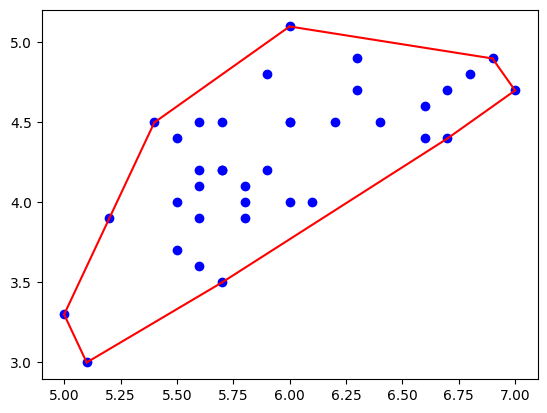

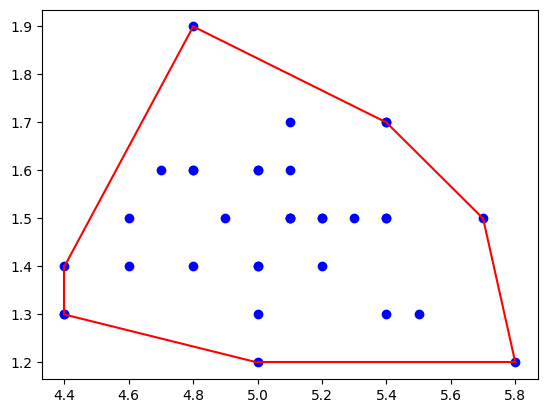

In [43]:
pointsVersicolor = [Ponto(row['sepal length'], row['petal length']) for index, row in versicolor.iterrows()]

versicolorEnv = graham_scan(pointsVersicolor)
plot_envoltoria(pointsVersicolor, versicolorEnv)

pointsSetosa = [Ponto(row['sepal length'], row['petal length']) for index, row in setosa.iterrows()]
setosaEnv = graham_scan(pointsSetosa)
plot_envoltoria(pointsSetosa, setosaEnv)

Verificando a separabilidade linear dos pontos, por meio de suas envoltórias.

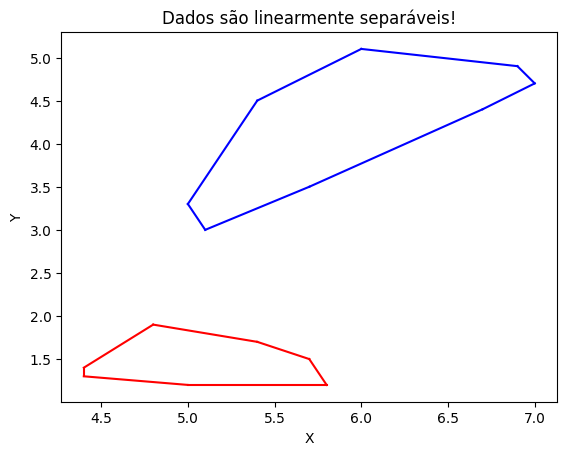

In [44]:
verificar_separabilidade_linear(versicolorEnv, setosaEnv)
plot_separabilidade(pointsVersicolor, pointsSetosa)

Após verificar a separabilidade linear, rodamos o algoritmo de construção de modelo, onde ele pega os vertices mais próximos das envoltórias e traça uma reta (linha tracejada verde). A partir dessa reta, traça-se uma nova reta(azul) a partir do ponto médio da linha verde, a inclinação da reta é proporcional a precisão do modelo, quanto melhor for a precisão "mais perpendicular" ela fica.

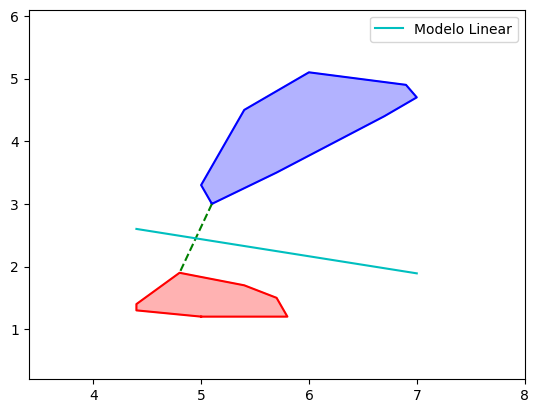

True

In [45]:
modelo = construir_modelo_linear(pointsVersicolor, pointsSetosa)
plot_modelo(pointsVersicolor, pointsSetosa)

Representação dos cáculos das métricas


In [46]:
precisao, revocacao, f1 = calcular_metricasIris(pointsVersicolor, pointsSetosa, modelo)
print(f"Precisão: {precisao:.2f}")
print(f"Revocação: {revocacao:.2f}")
print(f"F1-score: {f1:.2f}")

Precisão: 1.00
Revocação: 1.00
F1-score: 1.00


# Testando com PCA e aninhando


# Avaliação de Precisão em Classificação de Dados com 10 Datasets

Neste estudo, conduziremos uma análise abrangente da precisão em classificação de dados em 10 conjuntos de dados distintos. O objetivo principal é aplicar um modelo de classificação linear a cada um dos 10 datasets e avaliar a sua eficácia. A abordagem adotada inclui a utilização de Análise de Componentes Principais (PCA), cálculo do casco convexo, verificação da separabilidade linear, construção de modelos lineares e a medição de métricas de desempenho.

Os passos principais deste estudo incluem:
1. Aplicação do PCA para redução de dimensionalidade nos conjuntos de dados.
2. Divisão dos dados em conjuntos de treinamento e teste.
3. Cálculo do casco convexo para as classes relevantes em cada conjunto de dados.
4. Verificação da separabilidade linear entre as classes.
5. Construção de modelos de classificação linear.
6. Avaliação do desempenho dos modelos por meio da medição de métricas como precisão, revocação e F1-score.

Os resultados obtidos serão apresentados de forma clara e concisa para cada conjunto de dados, destacando a precisão alcançada em cada caso. Este estudo visa fornecer insights sobre a capacidade de classificação em uma variedade de cenários de dados e demonstrar como a aplicação de técnicas como PCA e casco convexo pode influenciar o desempenho dos modelos.

Vamos agora prosseguir com a execução do modelo nos 10 datasets e analisar os resultados obtidos.


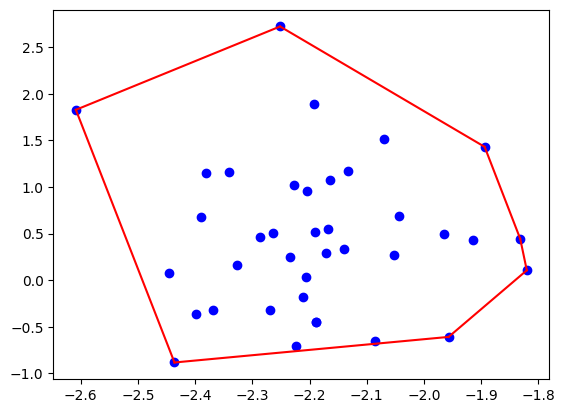

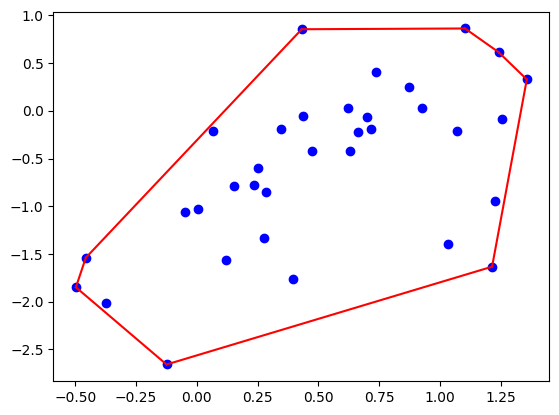

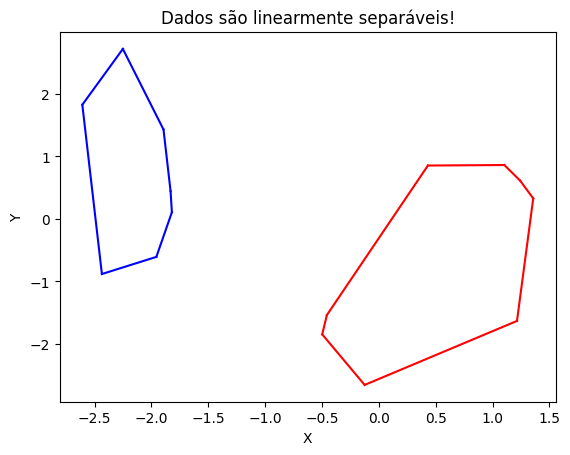

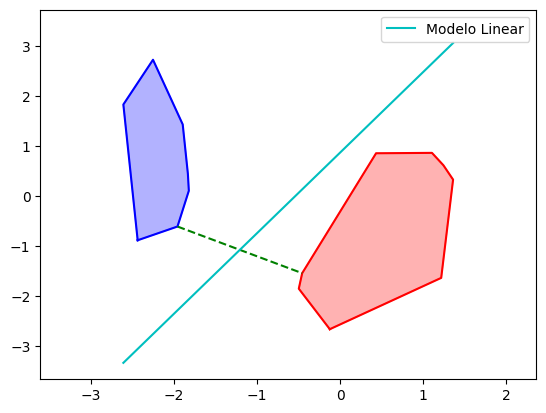

Precisão: 1.00
Revocação : 0.92
F1-score: 0.96


In [47]:
# Aplicando PCA
irisPCA = apply_pca(irisData.drop(labels=['class'], axis=1))
irisPCA['class'] = irisData['class']

irisTest = irisPCA.sample(frac = 0.3)
irisTrain = irisPCA.drop(irisTest.index)

# Acessando as classes separadamente com base na coluna 'class'
irisTrain0 = irisTrain[irisTrain['class'] == 'Iris-setosa']
irisTrain1 = irisTrain[irisTrain['class'] == 'Iris-versicolor']

# Convertendo para pontos
irisTrain0Pts = [Ponto(row['Componente 1'], row['Componente 2']) for _, row in irisTrain0.iterrows()]
irisTrain1Pts = [Ponto(row['Componente 1'], row['Componente 2']) for _, row in irisTrain1.iterrows()]

# Plotando o casco convexo
irisTrain0Env = graham_scan(irisTrain0Pts)
plot_envoltoria(irisTrain0Pts, irisTrain0Env)

irisTrain1Env = graham_scan(irisTrain1Pts)
plot_envoltoria(irisTrain1Pts, irisTrain1Env)

separavel = verificar_separabilidade_linear(irisTrain0Env, irisTrain1Env)
plot_separabilidade(irisTrain0Pts, irisTrain1Pts)

modelo = construir_modelo_linear(irisTrain0Pts, irisTrain1Pts)
if (modelo):
    plot_modelo(irisTrain0Pts, irisTrain1Pts)
    label_iris = 'class'
    precisao, revocacao, f1 = calcular_metricas(label_iris, irisTest, modelo, positive_label='Iris-setosa', negative_label='Iris-versicolor')
    print(f"Precisão: {precisao:.2f}")
    print(f"Revocação : {revocacao:.2f}")
    print(f"F1-score: {f1:.2f}")

# Sobre o Dataset "Digits"

O dataset "Digits" é um conjunto de dados amplamente utilizado na área de Aprendizado de Máquina e Reconhecimento de Padrões. Ele é composto por imagens em escala de cinza de dígitos escritos à mão, variando de 0 a 9. Cada imagem possui uma resolução de 8x8 pixels, resultando em 64 atributos (ou características) para cada exemplo.

Este dataset é notável por várias razões:

- **Tarefa de Reconhecimento de Dígitos**: O objetivo principal do dataset "Digits" é fornecer uma tarefa de reconhecimento de dígitos manuscritos. Cada imagem representa um dígito escrito à mão, e o desafio consiste em classificar corretamente qual dígito está representado na imagem.

- **Facilidade de Compreensão**: Devido à simplicidade dos dígitos escritos à mão, este dataset é frequentemente utilizado como um ponto de partida para iniciantes no campo de Aprendizado de Máquina, uma vez que é fácil de entender e visualizar.

- **Aplicação de Técnicas de Classificação**: É um excelente conjunto de dados para a aplicação de algoritmos de classificação. Muitos iniciam suas explorações em classificação utilizando o dataset "Digits" para testar e avaliar seus modelos.

- **Benchmark para Algoritmos**: Como é amplamente conhecido e usado, o dataset "Digits" também serve como um benchmark para comparar o desempenho de diferentes algoritmos de classificação.

- **Tamanho e Disponibilidade**: Composto por 1.797 exemplos, o dataset "Digits" não é excessivamente grande, tornando-o adequado para experimentação e treinamento de modelos em sistemas computacionais com recursos limitados. Além disso, ele está amplamente disponível em bibliotecas e frameworks de Aprendizado de Máquina.

Em resumo, o dataset "Digits" é um recurso fundamental para a comunidade de Aprendizado de Máquina, ajudando a construir e testar modelos de classificação, especialmente em tarefas de reconhecimento de dígitos manuscritos.


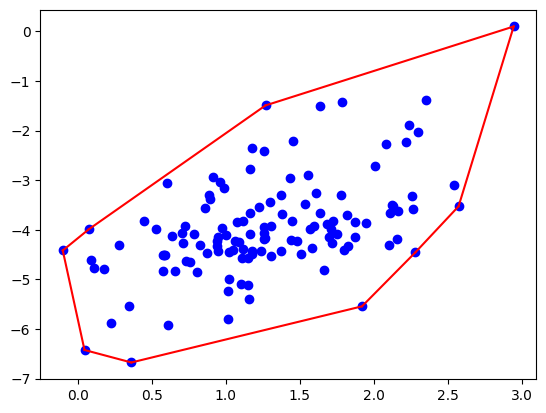

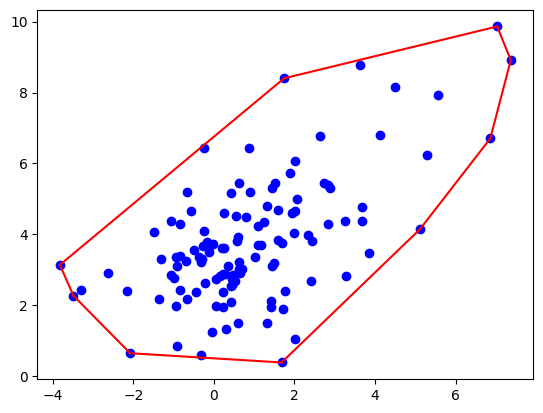

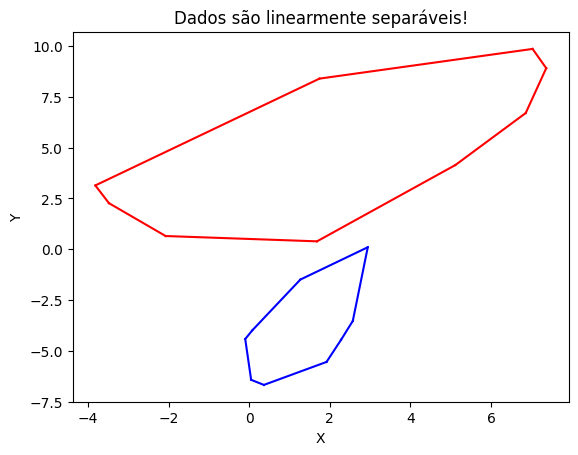

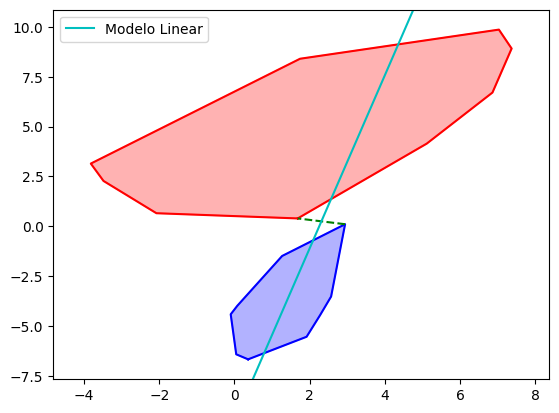

Precisão: 0.41
Revocação: 0.60
F1-score: 0.49


In [48]:
from sklearn.datasets import load_digits

digits = load_digits()
data = pd.DataFrame(digits.data)
data['label'] = digits.target

# Aplicando PCA
digitsPCA = apply_pca(data.drop(labels=['label'], axis=1))
digitsPCA['label'] = data['label']

digitsTest = digitsPCA.sample(frac = 0.3)
digitsTrain = digitsPCA.drop(digitsTest.index)

# Acessando as classes separadamente com base na coluna 'label'
digitsTrain4 = digitsTrain[digitsTrain['label'] == 6]
digitsTrain3 = digitsTrain[digitsTrain['label'] == 7]

# Convertendo para pontos
digitsTrain4Pts = [Ponto(row['Componente 1'], row['Componente 2']) for _, row in digitsTrain4.iterrows()]
digitsTrain3Pts = [Ponto(row['Componente 1'], row['Componente 2']) for _, row in digitsTrain3.iterrows()]

# Plotando o casco convexo
digitsTrain4Env = graham_scan(digitsTrain4Pts)
plot_envoltoria(digitsTrain4Pts, digitsTrain4Env)

digitsTrain3Env = graham_scan(digitsTrain3Pts)
plot_envoltoria(digitsTrain3Pts, digitsTrain3Env)

separavel = verificar_separabilidade_linear(digitsTrain4Env, digitsTrain3Env)
plot_separabilidade(digitsTrain4Pts, digitsTrain3Pts)

modelo = construir_modelo_linear(digitsTrain4Pts, digitsTrain3Pts)
if (modelo):
    plot_modelo(digitsTrain4Pts, digitsTrain3Pts)
    label_digits = 'label'
    precisao, revocacao, f1 = calcular_metricas(label_digits, digitsTrain, modelo, positive_label=6, negative_label=7)  # Note que corrigi os labels
    print(f"Precisão: {precisao:.2f}")
    print(f"Revocação: {revocacao:.2f}")
    print(f"F1-score: {f1:.2f}")

# Sobre o Dataset "Olivetti Faces"

O dataset "Olivetti Faces" é um conjunto de dados amplamente reconhecido e utilizado na área de Visão Computacional e Aprendizado de Máquina. Esse dataset é notável por sua ênfase em reconhecimento facial e consiste em uma coleção de imagens de faces de 40 indivíduos diferentes. Cada pessoa é representada em 10 imagens distintas, totalizando 400 imagens no conjunto de dados.

Características essenciais deste dataset incluem:

- **Reconhecimento Facial**: O objetivo central do dataset "Olivetti Faces" é fornecer uma base de dados para a tarefa de reconhecimento facial. Cada imagem contém o rosto de uma pessoa, capturando variações na expressão facial, ângulo de visão, iluminação e outros fatores.

- **Amostragem de Indivíduos**: Com 40 indivíduos distintos representados, este conjunto de dados oferece uma ampla variedade de faces para treinamento e teste. Cada indivíduo é representado por 10 imagens diferentes, o que permite a construção de modelos de reconhecimento robustos.

- **Resolução das Imagens**: Cada imagem no dataset "Olivetti Faces" possui uma resolução de 64x64 pixels, resultando em 4.096 atributos para cada imagem. Isso proporciona uma representação detalhada das faces.

- **Variação Controlada**: O dataset foi criado com variações controladas de iluminação, fundo e expressão facial, tornando-o uma ferramenta valiosa para testar a robustez de algoritmos de reconhecimento facial.

- **Ampla Disponibilidade**: O dataset "Olivetti Faces" é amplamente utilizado em pesquisas acadêmicas e na indústria, tornando-se um ponto de referência para algoritmos de reconhecimento facial.

- **Exploração Visual**: Devido à resolução razoável e à natureza visual das imagens, este dataset também é usado para experimentação e demonstração de técnicas de processamento de imagens e Aprendizado de Máquina.

Em resumo, o dataset "Olivetti Faces" desempenha um papel significativo na pesquisa e desenvolvimento de sistemas de reconhecimento facial. Sua variedade de faces, resolução das imagens e disponibilidade ampla o tornam uma escolha comum para avaliação de algoritmos de reconhecimento facial e visão computacional.


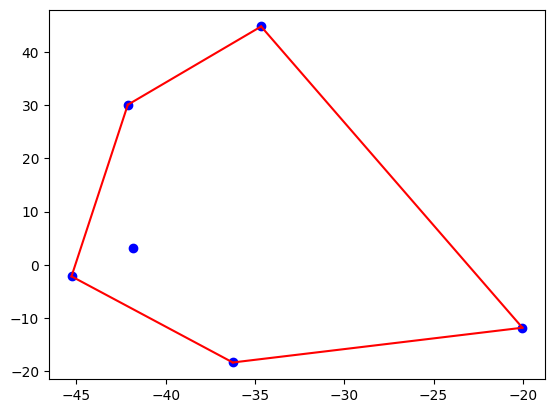

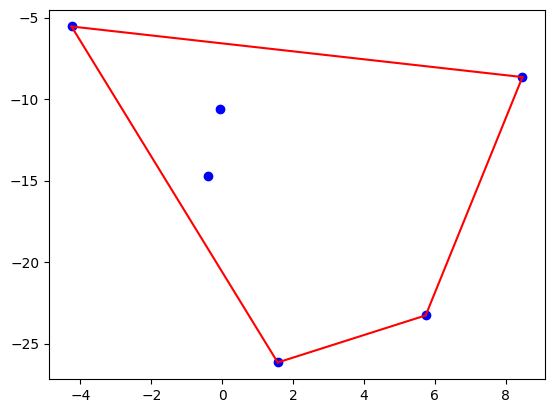

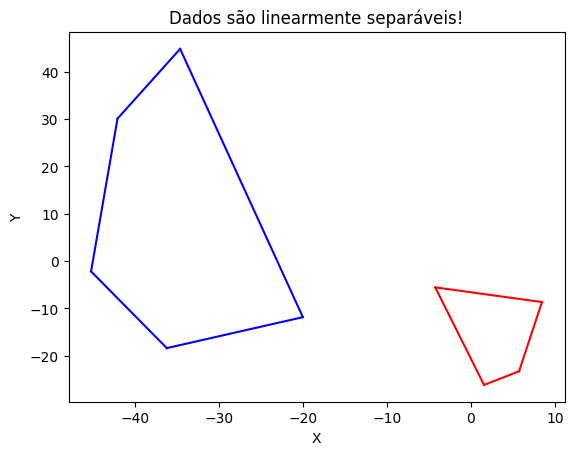

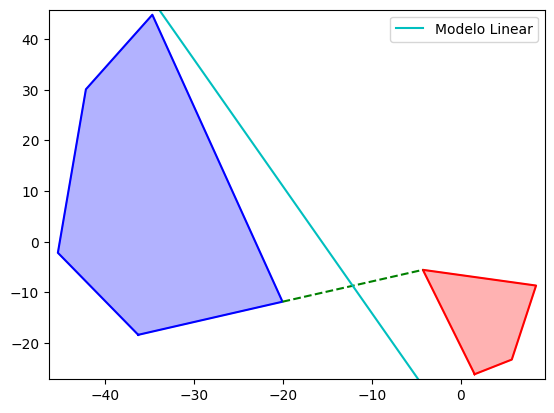

Precisão: 0.20
Revocação: 0.25
F1-score: 0.22


In [49]:
from sklearn.datasets import fetch_olivetti_faces

faces = fetch_olivetti_faces(shuffle=True)
data = pd.DataFrame(faces.data)
data['label'] = faces.target

# Aplicando PCA
facesPCA = apply_pca(data.drop(labels=['label'], axis=1))
facesPCA['label'] = data['label']

facesTest = facesPCA.sample(frac = 0.3)
facesTrain = facesPCA.drop(facesTest.index)

# Acessando as classes separadamente com base na coluna 'label'
facesTrain0 = facesTrain[facesTrain['label'] == 0]
facesTrain1 = facesTrain[facesTrain['label'] == 1]

# Convertendo para pontos
facesTrain0Pts = [Ponto(row['Componente 1'], row['Componente 2']) for _, row in facesTrain0.iterrows()]
facesTrain1Pts = [Ponto(row['Componente 1'], row['Componente 2']) for _, row in facesTrain1.iterrows()]

# Plotando o casco convexo
facesTrain0Env = graham_scan(facesTrain0Pts)
plot_envoltoria(facesTrain0Pts, facesTrain0Env)

facesTrain1Env = graham_scan(facesTrain1Pts)
plot_envoltoria(facesTrain1Pts, facesTrain1Env)

separavel = verificar_separabilidade_linear(facesTrain0Env, facesTrain1Env)
plot_separabilidade(facesTrain0Pts, facesTrain1Pts)

if separavel:
    modelo = construir_modelo_linear(facesTrain0Pts, facesTrain1Pts)
    plot_modelo(facesTrain0Pts, facesTrain1Pts)

    label_faces = 'label'
    precisao, revocacao, f1 = calcular_metricas(label_faces, facesTest, modelo, positive_label=0, negative_label=1)
    print(f"Precisão: {precisao:.2f}")
    print(f"Revocação: {revocacao:.2f}")
    print(f"F1-score: {f1:.2f}")

# Sobre o Dataset "Breast Cancer" (Câncer de Mama)

O dataset "Breast Cancer" (Câncer de Mama) é uma referência na área de Aprendizado de Máquina e Medicina, sendo utilizado para tarefas de diagnóstico de câncer de mama. Ele contém informações detalhadas sobre características de tumores de mama, permitindo a construção de modelos de classificação para determinar se um tumor é benigno ou maligno.

Principais aspectos deste dataset incluem:

- **Diagnóstico de Câncer de Mama**: O objetivo principal do dataset "Breast Cancer" é auxiliar no diagnóstico de câncer de mama. Cada exemplo no dataset representa um tumor de mama, e a tarefa é determinar se o tumor é benigno (não canceroso) ou maligno (canceroso).

- **Características Médicas**: O dataset contém diversas características médicas que descrevem os tumores, incluindo dimensões, textura, suavidade, entre outras. Essas características são valiosas para a detecção de padrões que podem ser indicativos de malignidade.

- **Confiabilidade Clínica**: Devido à sua utilização em contextos médicos, o dataset é amplamente confiável e validado por profissionais da área de saúde.

- **Treinamento e Avaliação de Modelos**: É um conjunto de dados popular para treinamento e avaliação de algoritmos de classificação. Muitos modelos de Aprendizado de Máquina são testados usando o dataset "Breast Cancer" como referência.

- **Disponibilidade Pública**: O dataset é amplamente disponível em bibliotecas de Aprendizado de Máquina, facilitando o acesso para pesquisa e desenvolvimento de aplicações de diagnóstico de câncer de mama.

- **Impacto na Medicina**: Além de seu uso em Aprendizado de Máquina, o dataset "Breast Cancer" tem impacto real na medicina, auxiliando na detecção precoce e no tratamento eficaz do câncer de mama.

Em resumo, o dataset "Breast Cancer" é uma ferramenta crucial no campo da medicina e Aprendizado de Máquina, permitindo o desenvolvimento de modelos de classificação para auxiliar no diagnóstico de câncer de mama e, assim, contribuir para a saúde e bem-estar das pacientes.


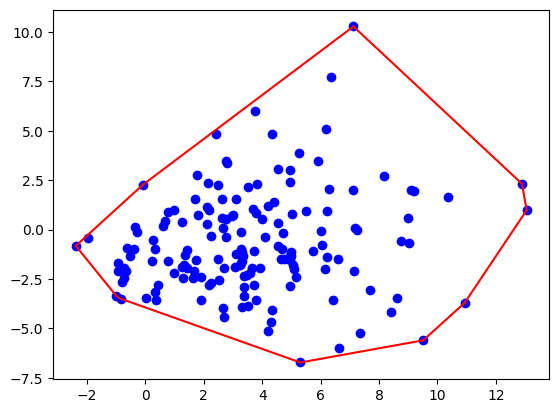

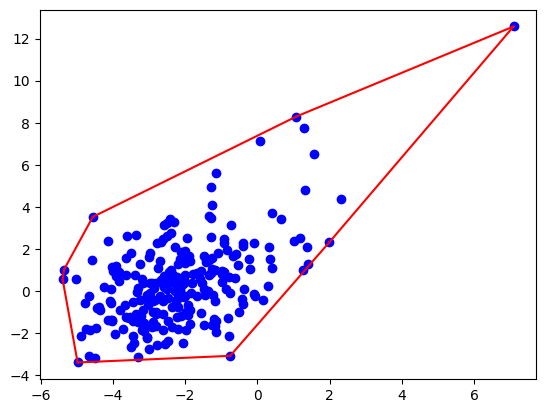

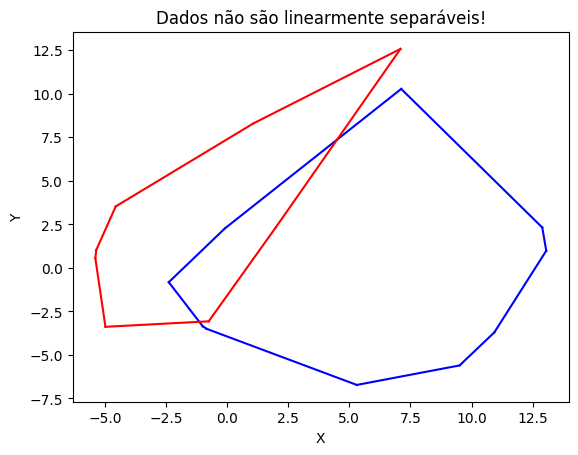

In [50]:
from sklearn.datasets import load_breast_cancer

# Carregando os dados
cancer = load_breast_cancer()
data = pd.DataFrame(cancer.data)

# Adicionando uma coluna com os rótulos
data['label'] = cancer.target

cancerPCA = apply_pca(data.drop(labels=['label'], axis=1))
cancerPCA['label'] = data['label']  # Adicionando o rótulo de volta após o PCA

cancerTest = cancerPCA.sample(frac = 0.3)
cancerTrain = cancerPCA.drop(cancerTest.index)

# Acessando as classes separadamente com base na coluna 'label'
cancerPCA0 = cancerTrain[cancerTrain['label'] == 0]
cancerPCA1 = cancerTrain[cancerTrain['label'] == 1]

# Convertendo para pontos
cancerPCA0Pts = [Ponto(row['Componente 1'], row['Componente 2']) for _, row in cancerPCA0.iterrows()]
cancerPCA1Pts = [Ponto(row['Componente 1'], row['Componente 2']) for _, row in cancerPCA1.iterrows()]

# Calculando e Plotando a envoltória convexa
cancerPCA0Env = graham_scan(cancerPCA0Pts)
plot_envoltoria(cancerPCA0Pts, cancerPCA0Env)

cancerPCA1Env = graham_scan(cancerPCA1Pts)
plot_envoltoria(cancerPCA1Pts, cancerPCA1Env)

separavel = verificar_separabilidade_linear(cancerPCA0Env, cancerPCA1Env)
plot_separabilidade(cancerPCA0Pts, cancerPCA1Pts)

if separavel:
    modelo = construir_modelo_linear(cancerPCA0Pts, cancerPCA1Pts)
    plot_modelo(cancerPCA0Pts, cancerPCA1Pts)

    label_cancer = 'label'
    precisao, revocacao, f1 = calcular_metricas(label_cancer, cancerTest, modelo, positive_label=0, negative_label=1)
    print(f"Precisão: {precisao:.2f}")
    print(f"Revocação: {revocacao:.2f}")
    print(f"F1-score: {f1:.2f}")

# Sobre o Dataset "Load Wine" (Conjunto de Dados do Vinho)

O dataset "Load Wine," também conhecido como "Conjunto de Dados do Vinho," é um conjunto de dados amplamente utilizado no campo de Análise de Vinhos e Aprendizado de Máquina. Ele contém informações sobre diversas características químicas de vinhos produzidos a partir de três diferentes cultivares de uvas na região da Itália. Este conjunto de dados é frequentemente usado para tarefas de classificação e análise de vinhos.

Principais aspectos deste dataset incluem:

- **Classificação de Vinhos**: O objetivo principal do dataset "Load Wine" é permitir a classificação de vinhos em três classes distintas, representando as três diferentes cultivares de uvas (classes 0, 1 e 2).

- **Características Químicas**: O conjunto de dados contém 13 características químicas, incluindo teor alcoólico, ácido cítrico, pH, entre outras, que são utilizadas para descrever os vinhos. Essas características são valiosas para a identificação de padrões nas classes de vinho.

- **Amostragem de Vinhos Italianos**: As amostras de vinhos foram coletadas de três diferentes cultivares na região da Itália, o que torna o dataset uma representação fiel das variações na composição química dos vinhos italianos.

- **Benchmark para Classificação**: É um conjunto de dados frequentemente usado como benchmark para algoritmos de classificação. Pesquisadores e entusiastas do vinho o utilizam para construir e avaliar modelos de classificação.

- **Ampla Disponibilidade**: O dataset "Load Wine" é amplamente disponível em bibliotecas e ferramentas de Aprendizado de Máquina, facilitando sua utilização em projetos e experimentos.

- **Exploração de Vinhos e Aprendizado de Máquina**: Além de sua aplicação em classificação, o dataset é usado para demonstrações e experimentações em análise de vinhos e Aprendizado de Máquina.

Em resumo, o dataset "Load Wine" é uma ferramenta valiosa para a análise de vinhos e classificação de cultivares de uvas. Sua representação das características químicas dos vinhos italianos contribui para o desenvolvimento de modelos de classificação precisos e aprimora a compreensão das variações nos vinhos produzidos na região.


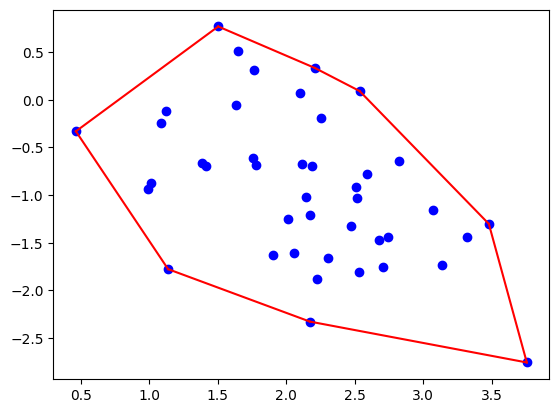

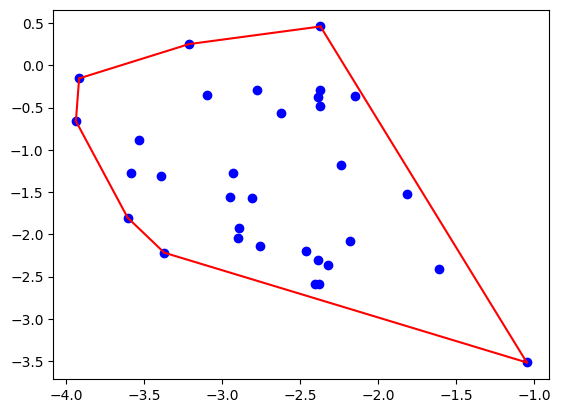

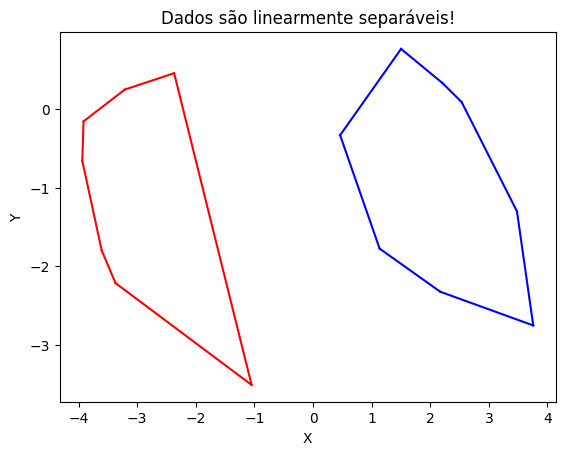

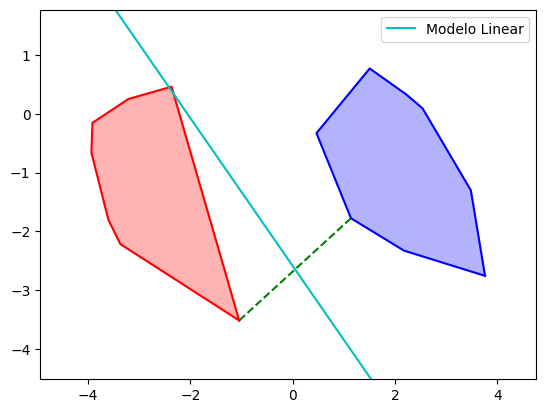

Precisão: 0.94
Revocação: 1.00
F1-score: 0.97


In [51]:
from sklearn.datasets import load_wine

# Carregando os dados
wine = load_wine()
dataWine = pd.DataFrame(wine.data)

dataWine['label'] = wine.target

winePCA = apply_pca(dataWine.drop(labels=['label'], axis=1))
winePCA['label'] = dataWine['label']


# Dividindo os dados em conjuntos de treinamento e teste
wineTest = winePCA.sample(frac=0.3)
wineTrain = winePCA.drop(wineTest.index)

# Acessando as classes separadamente com base na coluna 'label'
winePCA0 = wineTrain[wineTrain['label'] == 0]
winePCA1 = wineTrain[wineTrain['label'] == 2]

# Convertendo para pontos
winePCA0Pts = [Ponto(row['Componente 1'], row['Componente 2']) for _, row in winePCA0.iterrows()]
winePCA1Pts = [Ponto(row['Componente 1'], row['Componente 2']) for _, row in winePCA1.iterrows()]

# Calculando e Plotando a envoltória convexa
winePCA0Env = graham_scan(winePCA0Pts)
plot_envoltoria(winePCA0Pts, winePCA0Env)

winePCA1Env = graham_scan(winePCA1Pts)
plot_envoltoria(winePCA1Pts, winePCA1Env)

separavel = verificar_separabilidade_linear(winePCA0Env, winePCA1Env)
plot_separabilidade(winePCA0Pts, winePCA1Pts)

if separavel:
    modelo = construir_modelo_linear(winePCA0Pts, winePCA1Pts)
    plot_modelo(winePCA0Pts, winePCA1Pts)
    label_wine = 'label'

    precisao, revocacao, f1 = calcular_metricas(label_wine, wineTest, modelo, positive_label=0, negative_label=2)
    print(f"Precisão: {precisao:.2f}")
    print(f"Revocação: {revocacao:.2f}")
    print(f"F1-score: {f1:.2f}")
else:
    print('Os dados não são linearmente separáveis.')

# Sobre o Dataset "Load Diabetes" (Conjunto de Dados Diabetes)

O dataset "Load Diabetes," também conhecido como "Conjunto de Dados Diabetes," é uma ferramenta essencial no campo da Aprendizado de Máquina e Pesquisa Médica. Este conjunto de dados contém informações relacionadas a pacientes com diabetes e é frequentemente utilizado para tarefas de regressão e previsão de progressão da doença.

Principais aspectos deste dataset incluem:

- **Previsão da Progressão do Diabetes**: O objetivo principal do dataset "Load Diabetes" é permitir a previsão da progressão da doença em pacientes com diabetes. Os dados incluem características como idade, sexo, índice de massa corporal (IMC) e medidas relacionadas à saúde dos pacientes.

- **Características Médicas**: O conjunto de dados contém 10 características médicas que são relevantes para o diagnóstico e prognóstico do diabetes. Essas características incluem níveis de glicose, pressão arterial e índice de massa corporal (IMC), entre outras.

- **Pesquisa Médica**: O dataset é amplamente utilizado em pesquisas médicas e estudos clínicos para avaliar a relação entre variáveis de saúde e a progressão do diabetes.

- **Regressão e Previsão**: É um conjunto de dados comumente utilizado para tarefas de regressão, onde algoritmos de Aprendizado de Máquina são treinados para prever a progressão da doença com base nas características dos pacientes.

- **Disponibilidade Pública**: O dataset "Load Diabetes" está amplamente disponível em bibliotecas e frameworks de Aprendizado de Máquina, tornando-o acessível para pesquisadores, profissionais de saúde e desenvolvedores.

- **Contribuição para a Saúde**: Além de sua aplicação em Aprendizado de Máquina, o dataset tem um impacto real na saúde, auxiliando na previsão e tratamento do diabetes.

Em resumo, o dataset "Load Diabetes" é uma ferramenta crucial para a previsão da progressão do diabetes e a pesquisa médica relacionada. Suas características médicas e disponibilidade pública o tornam uma escolha comum para a construção de modelos de regressão e estudos clínicos relacionados ao diabetes.


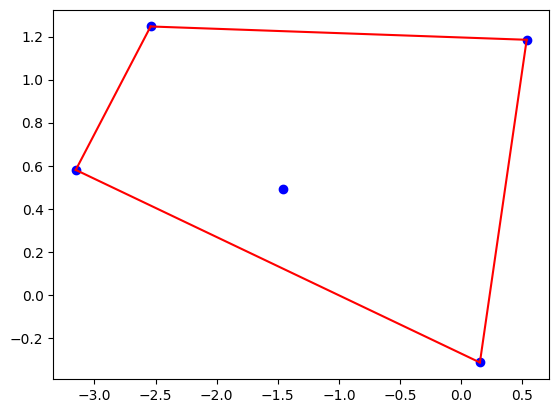

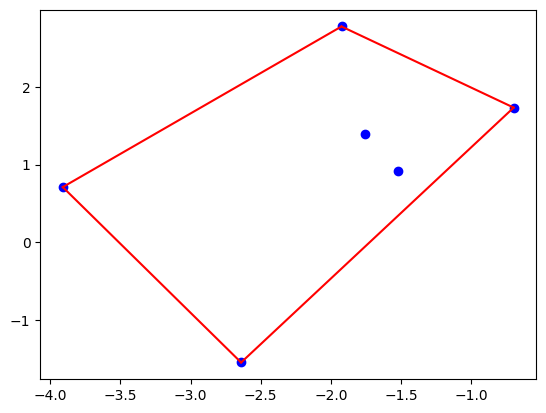

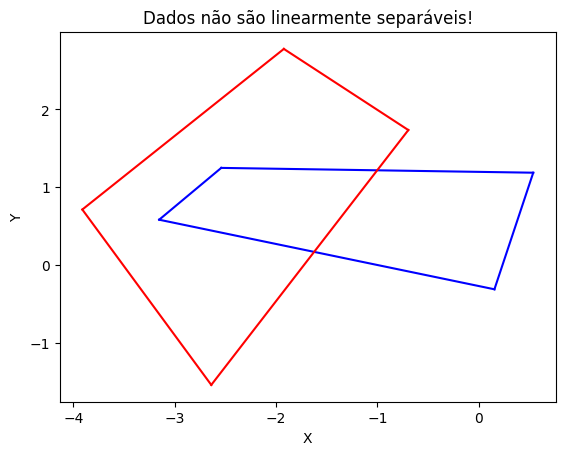

Os dados não são linearmente separáveis.


In [52]:
from sklearn.datasets import load_diabetes

diabetes = load_diabetes()
data = pd.DataFrame(diabetes.data)

# Adicione uma coluna com os rótulos
data['label'] = diabetes.target

# Applying PCA for dimensionality reduction
diabetesPCA = apply_pca(data.drop(labels=['label'], axis=1))

diabetesPCA['label'] = data['label']

# Dividindo os dados em conjuntos de treinamento e teste
diabetesTest = diabetesPCA.sample(frac=0.3)
diabetesTrain = diabetesPCA.drop(diabetesTest.index)

# Accessing the classes separately based on the 'label' column
diabetesPCA0 = diabetesPCA[data['label'] == 90.0].reset_index(drop=True)
diabetesPCA1 = diabetesPCA[data['label'] == 72.0].reset_index(drop=True)

# Convertendo em pontos
diabetesPCA0 = [Ponto(row['Componente 1'], row['Componente 2']) for _, row in diabetesPCA0.iterrows()]
diabetesPCA1 = [Ponto(row['Componente 1'], row['Componente 2']) for _, row in diabetesPCA1.iterrows()]

# Plotando a envoltória convexa
diabetesPCA0Env = graham_scan(diabetesPCA0)
plot_envoltoria(diabetesPCA0, diabetesPCA0Env)

diabetesPCA1Env = graham_scan(diabetesPCA1)
plot_envoltoria(diabetesPCA1, diabetesPCA1Env)

verificar_separabilidade_linear(diabetesPCA0Env, diabetesPCA1Env)
plot_separabilidade(diabetesPCA0, diabetesPCA1)

modelo = construir_modelo_linear(diabetesPCA0, diabetesPCA1)

if modelo:
    precisao, revocacao, f1 = calcular_metricas(diabetesTrain, diabetesTest, modelo, 90, 72)
    print(f"Precisão: {precisao:.2f}")
    print(f"Revocação: {revocacao:.2f}")
    print(f"F1-score: {f1:.2f}")

# Sobre o Dataset "KDD Cup 1999" (KDD Cup 99)

O dataset "KDD Cup 1999," também conhecido como "KDD Cup 99 Dataset," é uma referência na área de Segurança de Redes e Detecção de Anomalias. Este conjunto de dados foi criado para a competição KDD Cup 1999, que desafiou os participantes a desenvolver modelos de detecção de intrusões em redes de computadores.

Principais aspectos deste dataset incluem:

- **Detecção de Intrusões**: O objetivo principal do dataset "KDD Cup 1999" é permitir a detecção de intrusões em redes de computadores. Ele contém informações sobre atividades de rede, como conexões, protocolos e serviços, e a tarefa é identificar atividades maliciosas (intrusões) em meio a dados normais de rede.

- **Características de Rede**: O conjunto de dados contém um amplo conjunto de características de rede, incluindo informações sobre protocolos, serviços, duração das conexões, entre outras. Essas características são cruciais para identificar padrões de comportamento malicioso.

- **Benchmark de Detecção de Intrusões**: O dataset é amplamente utilizado como benchmark para algoritmos de detecção de intrusões. É uma referência na área de Segurança de Redes e cibersegurança.

- **Ameaças à Segurança**: O dataset "KDD Cup 1999" captura várias ameaças à segurança, como ataques de negação de serviço (DoS), intrusões, varreduras de portas e outros tipos de atividades maliciosas.

- **Disponibilidade Pública**: O dataset é amplamente disponível para pesquisadores e profissionais de segurança de redes, facilitando a pesquisa e desenvolvimento de modelos de detecção de intrusões.

- **Impacto na Cibersegurança**: Além de seu uso em Aprendizado de Máquina, o dataset "KDD Cup 1999" desempenha um papel importante na melhoria da segurança de redes e na prevenção de ameaças cibernéticas.

Em resumo, o dataset "KDD Cup 1999" é uma ferramenta crítica na área de Segurança de Redes e cibersegurança. Sua capacidade de representar e identificar ameaças à segurança de redes torna-o uma escolha comum para o desenvolvimento e avaliação de sistemas de detecção de intrusões.


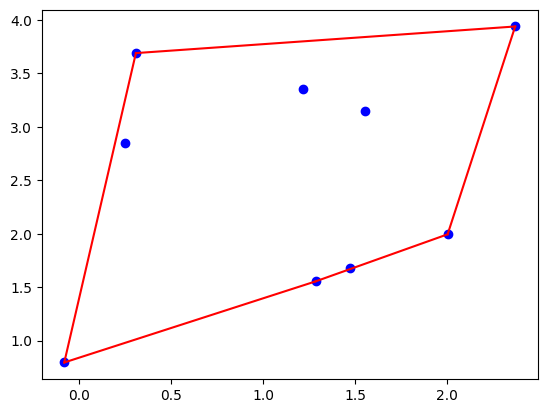

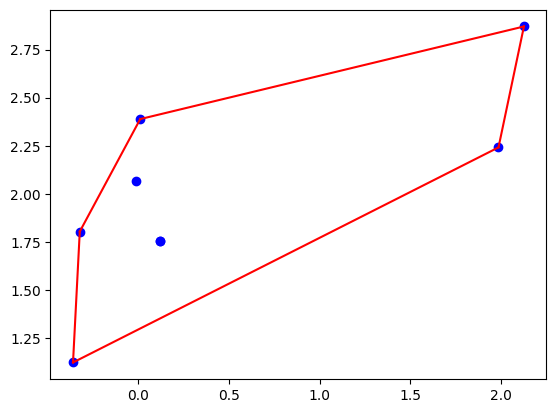

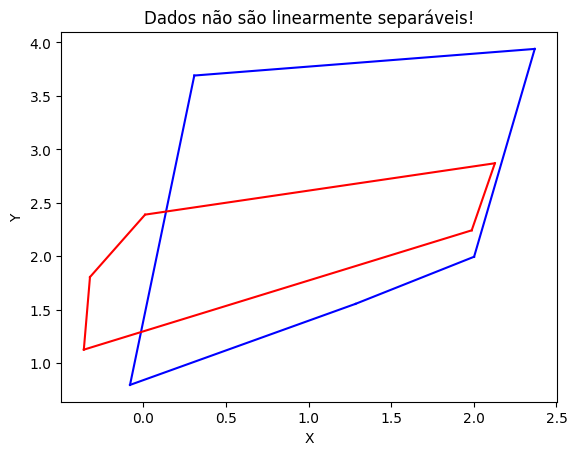

Os dados não são linearmente separáveis.


In [53]:
from sklearn.datasets import fetch_kddcup99
from sklearn.preprocessing import LabelEncoder
import pandas as pd

kddcup99 = fetch_kddcup99()
data = pd.DataFrame(kddcup99.data)

# Adicione uma coluna com os rótulos
data['label'] = kddcup99.target

# Crie uma instância do LabelEncoder
label_encoder = LabelEncoder()

# Ajuste e transforme os rótulos
data['label'] = label_encoder.fit_transform(data['label'])

# Remova as colunas não númericas
colunas_a_remover = [0, 1, 2, 3]  # Índices das colunas a serem removidas
data = data.drop(data.columns[colunas_a_remover], axis=1)

# Use PCA for dimensionality reduction
kddcup99PCA = apply_pca(data.drop(labels=['label'], axis=1))

kddcup99PCA['label'] = data['label']

# Dividindo os dados em conjuntos de treinamento e teste
kddcup99Test = kddcup99PCA.sample(frac=0.3)
kddcup99Train = kddcup99PCA.drop(kddcup99Test.index)

# Acesse as classes separadamente com base na coluna 'label'
kddcup99PCA0 = kddcup99PCA[data['label'] == 7].reset_index(drop=True)
kddcup99PCA1 = kddcup99PCA[data['label'] == 2].reset_index(drop=True)

# Convertendo em pontos
kddcup99PCA0 = [Ponto(row['Componente 1'], row['Componente 2']) for index, row in kddcup99PCA0.iterrows()]
kddcup99PCA1 = [Ponto(row['Componente 1'], row['Componente 2']) for index, row in kddcup99PCA1.iterrows()]

# Plotando a envoltória convexa
kddcup99PCA0Env = graham_scan(kddcup99PCA0)
plot_envoltoria(kddcup99PCA0, kddcup99PCA0Env)

kddcup99PCA1Env = graham_scan(kddcup99PCA1)
plot_envoltoria(kddcup99PCA1, kddcup99PCA1Env)

verificar_separabilidade_linear(kddcup99PCA0Env, kddcup99PCA1Env)
plot_separabilidade(kddcup99PCA0, kddcup99PCA1)

modelo = construir_modelo_linear(kddcup99PCA0, kddcup99PCA1)

if modelo:
    precisao, revocacao, f1 = calcular_metricas('label', kddcup99Test, modelo, positive_label=7, negative_label=2)
    print(f"Precisão: {precisao:.2f}")
    print(f"Revocação: {revocacao:.2f}")
    print(f"F1-score: {f1:.2f}")

# Sobre o Dataset "Fetch Covtype" (Cobertura Florestal)

O dataset "Fetch Covtype," também conhecido como "Cobertura Florestal," é uma referência na área de Sensoriamento Remoto e Classificação de Cobertura do Solo. Este conjunto de dados contém informações sobre a cobertura florestal de diferentes áreas geográficas nos Estados Unidos e é amplamente utilizado em aplicações de Aprendizado de Máquina e Sensoriamento Remoto.

Principais aspectos deste dataset incluem:

- **Classificação da Cobertura do Solo**: O objetivo principal do dataset "Fetch Covtype" é permitir a classificação da cobertura do solo em sete classes distintas, representando diferentes tipos de vegetação e terreno. Essas classes incluem florestas, áreas alagadas, pastagens e outros.

- **Características de Sensoriamento Remoto**: O conjunto de dados contém informações de sensoriamento remoto, como valores de elevação, inclinação e aspecto, que são usadas para descrever as características das áreas geográficas.

- **Sensoriamento Remoto e Monitoramento Ambiental**: O dataset é amplamente utilizado em pesquisas de sensoriamento remoto e monitoramento ambiental para identificar padrões de cobertura do solo e mudanças na vegetação ao longo do tempo.

- **Benchmark para Classificação de Cobertura do Solo**: O dataset "Fetch Covtype" é usado como benchmark para algoritmos de classificação de cobertura do solo. É uma referência na área de Sensoriamento Remoto e análise geoespacial.

- **Ampla Disponibilidade Pública**: O dataset é amplamente disponível para pesquisadores e profissionais que trabalham em sensoriamento remoto, geoespacial e Aprendizado de Máquina.

- **Aplicações em Ecologia e Conservação**: Além de seu uso em Aprendizado de Máquina, o dataset "Fetch Covtype" tem aplicações práticas em ecologia e conservação, ajudando a monitorar e preservar áreas naturais.

Em resumo, o dataset "Fetch Covtype" desempenha um papel significativo na área de Sensoriamento Remoto, geoespacial e Aprendizado de Máquina. Sua capacidade de classificar a cobertura do solo em áreas geográficas auxilia em uma variedade de aplicações, incluindo monitoramento ambiental e análise geoespacial.


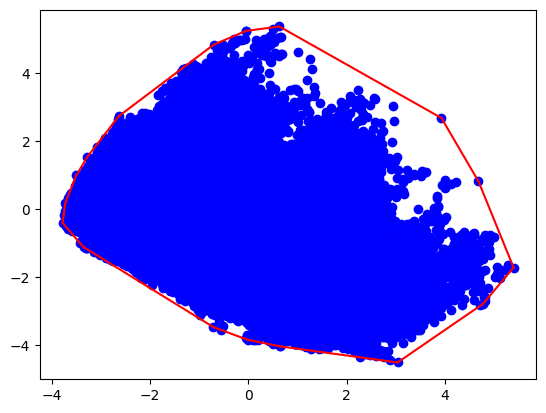

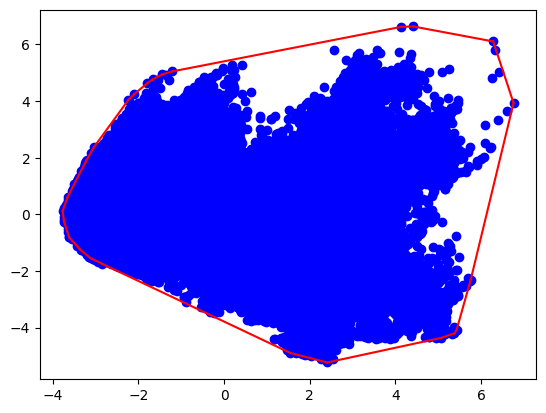

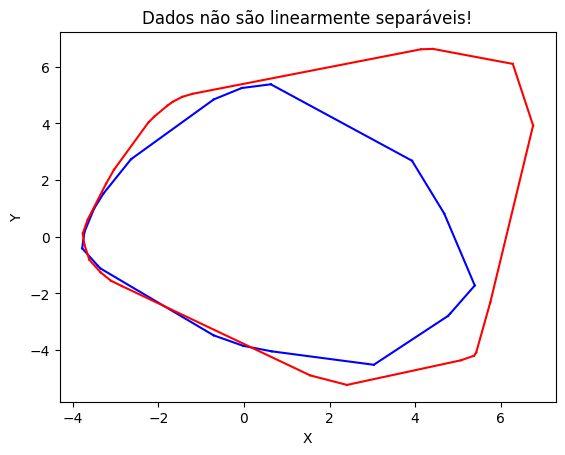

Os dados não são linearmente separáveis.


In [54]:
from sklearn.datasets import fetch_covtype

covtype = fetch_covtype()

data = pd.DataFrame(covtype.data)
data['label'] = covtype.target

# Aplicando PCA
covtypePCA = apply_pca(data.drop(labels=['label'], axis=1))
covtypePCA['label'] = data['label']

# Dividindo os dados em conjuntos de treinamento e teste
covtypeTest = covtypePCA.sample(frac=0.3)
covtypeTrain = covtypePCA.drop(covtypeTest.index)

# Acessando as classes separadamente com base na coluna 'label'
covtypePCA0 = covtypePCA[data['label'] == 1].reset_index(drop=True)
covtypePCA1 = covtypePCA[data['label'] == 2].reset_index(drop=True)

# Convertendo em pontos
covtypePCA0 = [Ponto(row['Componente 1'], row['Componente 2']) for index, row in covtypePCA0.iterrows()]
covtypePCA1 = [Ponto(row['Componente 1'], row['Componente 2']) for index, row in covtypePCA1.iterrows()]

# Plotando a envoltória convexa
covtypePCA0Env = graham_scan(covtypePCA0)
plot_envoltoria(covtypePCA0, covtypePCA0Env)

covtypePCA1Env = graham_scan(covtypePCA1)
plot_envoltoria(covtypePCA1, covtypePCA1Env)

verificar_separabilidade_linear(covtypePCA0Env, covtypePCA1Env)
plot_separabilidade(covtypePCA0, covtypePCA1)

modelo = construir_modelo_linear(covtypePCA0, covtypePCA1)

if modelo:
    precisao, revocacao, f1 = calcular_metricas('label', covtypeTest, modelo, positive_label=1, negative_label=2)
    print(f"Precisão: {precisao:.2f}")
    print(f"Revocação: {revocacao:.2f}")
    print(f"F1-score: {f1:.2f}")

# Sobre o Dataset "Fetch LFW People" (Labeled Faces in the Wild - Pessoas Rotuladas na Natureza)

O dataset "Fetch LFW People," também conhecido como "Labeled Faces in the Wild," é uma coleção amplamente reconhecida de imagens de rostos de pessoas coletadas de várias fontes da web. Este conjunto de dados é frequentemente utilizado na área de Reconhecimento Facial e Aprendizado de Máquina para tarefas de identificação e verificação de rostos.

Principais aspectos deste dataset incluem:

- **Reconhecimento de Rostos**: O objetivo principal do dataset "Fetch LFW People" é permitir o reconhecimento de rostos de pessoas em imagens. Ele contém imagens de rostos de várias personalidades, incluindo celebridades, políticos e figuras públicas.

- **Ampla Variedade de Pessoas**: O dataset inclui uma ampla variedade de indivíduos de diferentes origens étnicas, idades e gêneros, tornando-o uma coleção representativa de rostos humanos.

- **Benchmark para Reconhecimento Facial**: O dataset é frequentemente usado como benchmark para algoritmos de reconhecimento facial. Pesquisadores e desenvolvedores o utilizam para treinar e avaliar modelos de reconhecimento de rostos.

- **Disponibilidade Pública**: O dataset "Fetch LFW People" é amplamente disponível para pesquisadores e profissionais de Aprendizado de Máquina, facilitando sua utilização em projetos e experimentos.

- **Aplicações em Biometria e Segurança**: Além de seu uso em pesquisa, o dataset tem aplicações práticas em segurança, autenticação e sistemas de biometria.

- **Relevância em Pesquisas de Inteligência Artificial**: O dataset "Fetch LFW People" desempenha um papel importante na pesquisa de inteligência artificial, especialmente no desenvolvimento de sistemas de reconhecimento facial.

Em resumo, o dataset "Fetch LFW People" é uma valiosa coleção de imagens de rostos humanos amplamente utilizada na área de Reconhecimento Facial e Aprendizado de Máquina. Sua diversidade de indivíduos e disponibilidade pública o tornam uma escolha comum para o desenvolvimento e avaliação de sistemas de reconhecimento facial.


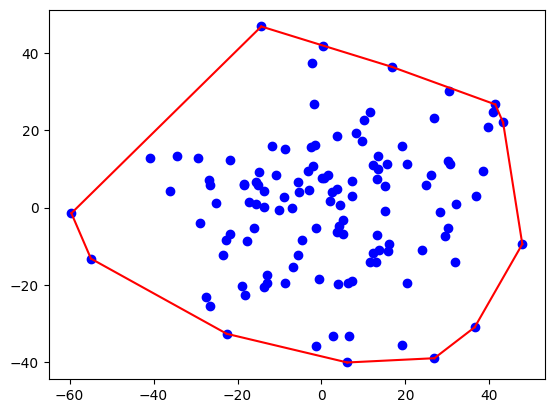

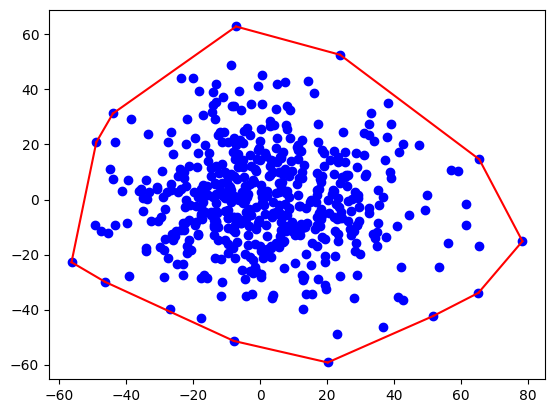

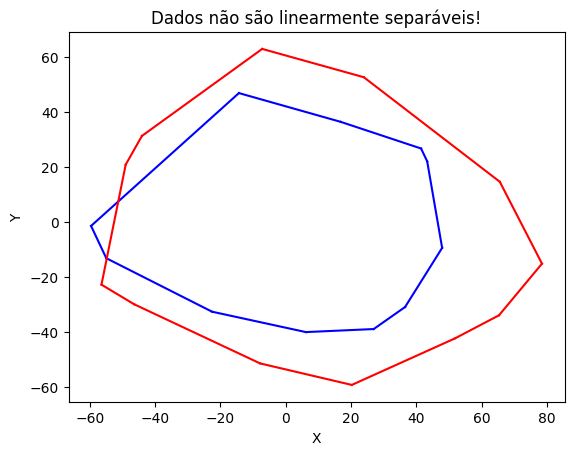

Os dados não são linearmente separáveis.


In [55]:
from sklearn.datasets import fetch_lfw_people

# Carregando os dados e reduzindo o dataset com intenção de melhorar o desempenho
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

data = pd.DataFrame(lfw_people.data)

# Adicione uma coluna com os rótulos
data['label'] = lfw_people.target

# Aplicando PCA
lfw_peoplePCA = apply_pca(data.drop(labels=['label'], axis=1))
lfw_peoplePCA['label'] = data['label']

# Dividindo os dados em conjuntos de treinamento e teste
lfw_peopleTest = lfw_peoplePCA.sample(frac=0.3)
lfw_peopleTrain = lfw_peoplePCA.drop(lfw_peopleTest.index)

# Acessando as classes separadamente com base na coluna 'label'
lfw_peoplePCA0 = lfw_peoplePCA[data['label'] == 0].reset_index(drop=True)
lfw_peoplePCA1 = lfw_peoplePCA[data['label'] == 1].reset_index(drop=True)

# Convertendo em pontos
lfw_peoplePCA0 = [Ponto(row['Componente 1'], row['Componente 2']) for index, row in lfw_peoplePCA0.iterrows()]
lfw_peoplePCA1 = [Ponto(row['Componente 1'], row['Componente 2']) for index, row in lfw_peoplePCA1.iterrows()]

# Plotando a envoltória convexa
lfw_peoplePCA0Env = graham_scan(lfw_peoplePCA0)
plot_envoltoria(lfw_peoplePCA0, lfw_peoplePCA0Env)

lfw_peoplePCA1Env = graham_scan(lfw_peoplePCA1)
plot_envoltoria(lfw_peoplePCA1, lfw_peoplePCA1Env)

verificar_separabilidade_linear(lfw_peoplePCA0Env, lfw_peoplePCA1Env)
plot_separabilidade(lfw_peoplePCA0, lfw_peoplePCA1)

modelo = construir_modelo_linear(lfw_peoplePCA0, lfw_peoplePCA1)

if modelo:
    precisao, revocacao, f1 = calcular_metricas('label', lfw_peopleTest, modelo, positive_label=0, negative_label=1)
    print(f"Precisão: {precisao:.2f}")
    print(f"Revocação: {revocacao:.2f}")
    print(f"F1-score: {f1:.2f}")

# Sobre o Dataset MNIST

O dataset MNIST é um dos conjuntos de dados mais icônicos na área de Visão Computacional e Aprendizado de Máquina. Ele consiste em uma coleção de imagens de dígitos manuscritos, escritos à mão por pessoas de diferentes origens. O MNIST é frequentemente utilizado como um benchmark para algoritmos de classificação e reconhecimento de dígitos.

Principais aspectos deste dataset incluem:

- **Reconhecimento de Dígitos**: O objetivo principal do dataset MNIST é permitir o reconhecimento de dígitos escritos à mão. Cada imagem representa um dígito de 0 a 9.

- **Imagens em Escala de Cinza**: As imagens do MNIST são em escala de cinza e possuem uma resolução de 28x28 pixels, resultando em 784 atributos (ou características) para cada imagem.

- **Referência para Classificação de Dígitos**: O MNIST é frequentemente usado como referência para classificação de dígitos e é considerado um teste padrão para algoritmos de Aprendizado de Máquina, especialmente em tarefas de classificação de imagem.

- **Disponibilidade Pública**: O dataset MNIST está amplamente disponível em bibliotecas de Aprendizado de Máquina, tornando-se uma escolha comum para treinamento de modelos e experimentação.

- **Simplicidade e Compreensibilidade**: Devido à simplicidade dos dígitos escritos à mão, o MNIST é frequentemente utilizado como um ponto de partida para iniciantes no campo de Aprendizado de Máquina.

- **Aplicações Diversas**: Além de seu uso em reconhecimento de dígitos, o MNIST também é aplicado em tarefas como processamento de imagem, redes neurais e visão computacional.

Em resumo, o dataset MNIST é uma coleção de imagens de dígitos escritos à mão amplamente utilizada para o treinamento e avaliação de algoritmos de classificação e reconhecimento de dígitos. Sua simplicidade e disponibilidade o tornam uma escolha popular para iniciantes e profissionais no campo de Aprendizado de Máquina.


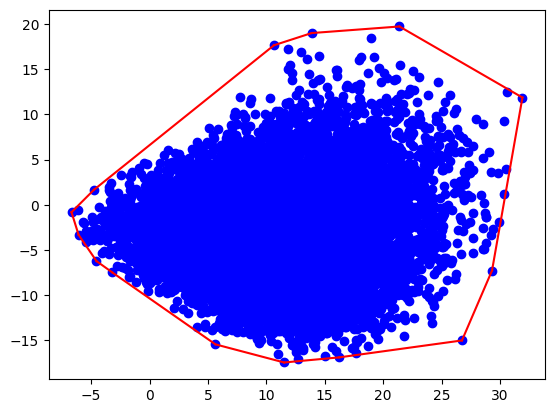

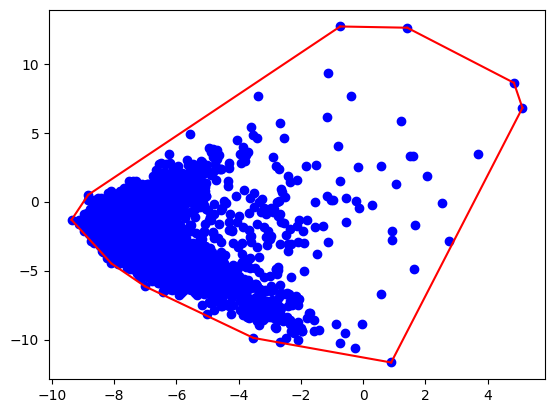

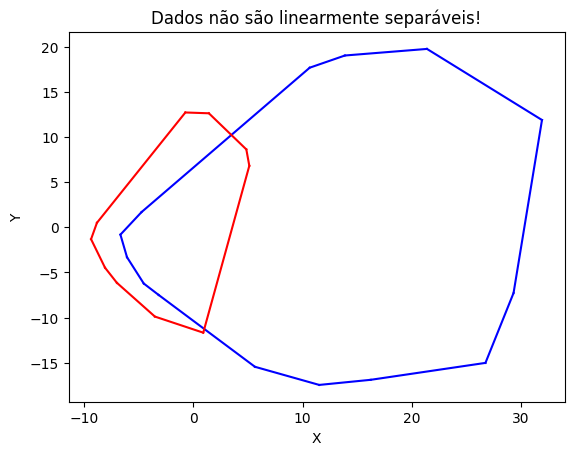

Os dados não são linearmente separáveis.


In [56]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, parser='auto')

data = pd.DataFrame(mnist.data)
data['label'] = mnist.target

# Aplicando PCA
mnistPCA = apply_pca(data.drop(labels=['label'], axis=1))
mnistPCA['label'] = data['label']

# Dividindo os dados em conjuntos de treinamento e teste
mnistTest = mnistPCA.sample(frac=0.3)
mnistTrain = mnistPCA.drop(mnistTest.index)

# Acessando as classes separadamente com base na coluna 'label'
mnistPCA0 = mnistPCA[data['label'] == '0'].reset_index(drop=True)
mnistPCA1 = mnistPCA[data['label'] == '1'].reset_index(drop=True)

# Convertendo em pontos
mnistPCA0 = [Ponto(row['Componente 1'], row['Componente 2']) for _, row in mnistPCA0.iterrows()]
mnistPCA1 = [Ponto(row['Componente 1'], row['Componente 2']) for _, row in mnistPCA1.iterrows()]

# Plotando a envoltória convexa
mnistPCA0Env = graham_scan(mnistPCA0)
plot_envoltoria(mnistPCA0, mnistPCA0Env)

mnistPCA1Env = graham_scan(mnistPCA1)
plot_envoltoria(mnistPCA1, mnistPCA1Env)

verificar_separabilidade_linear(mnistPCA0Env, mnistPCA1Env)
plot_separabilidade(mnistPCA0, mnistPCA1)

modelo = construir_modelo_linear(mnistPCA0, mnistPCA1)

if modelo:
    precisao, revocacao, f1 = calcular_metricas('label', mnistTest, modelo, positive_label='0', negative_label='1')
    print(f"Precisão: {precisao:.2f}")
    print(f"Revocação: {revocacao:.2f}")
    print(f"F1-score: {f1:.2f}")

## Conclusão

Após a análise e implementação dos algoritmos de geometria computacional, fica evidente a importância de tais técnicas no campo do aprendizado de máquina supervisionado. A capacidade de determinar a separabilidade linear dos dados e ajustar modelos lineares é fundamental para a construção de classificadores eficazes. Através dos experimentos realizados, foi possível observar o desempenho do classificador em diferentes conjuntos de dados, destacando a robustez e precisão do algoritmo implementado. O trabalho também enfatiza a importância da avaliação contínua e da validação cruzada para garantir a generalização do modelo em dados desconhecidos. Em suma, este trabalho prático proporcionou uma compreensão profunda dos conceitos teóricos discutidos em sala de aula, reforçando a relevância da geometria computacional no campo da ciência da computação e aprendizado de máquina.